In [46]:
%pip install scikit-learn pandas numpy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
#Thư viện
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from urllib.parse import urlparse
import re


In [12]:
folder = "C:/Users/Danny Phong/Documents/PROJECT/WebVulnerabilities/Data"
#data = pd.read_csv(folder + "/known_exploited_vulnerabilities.csv") 
data = pd.read_csv(folder + "/malicious_phish.csv") 
#data = pd.read_csv(folder + "/csic_database.csv")
print(data.head())

                                                 url        type
0                                   br-icloud.com.br    phishing
1                mp3raid.com/music/krizz_kaliko.html      benign
2                    bopsecrets.org/rexroth/cr/1.htm      benign
3  http://www.garage-pirenne.be/index.php?option=...  defacement
4  http://adventure-nicaragua.net/index.php?optio...  defacement


In [13]:
#string processing
def extract_features(url):
    parsed = urlparse(url)
    features = {}
    features["url_length"] = len(url)
    features["num_dots"] = url.count(".")
    features["num_hyphens"] = url.count("-")
    features["num_at"] = url.count("@")
    features["uses_https"] = int(parsed.scheme == "https")
    features["has_ip"] = int(bool(re.search(r'\d+\.\d+\.\d+\.\d+', parsed.netloc)))
    features["num_subdomains"] = len(parsed.netloc.split(".")) - 2  
    features["path_length"] = len(parsed.path)
    return features

# Áp dụng cho tất cả URL trong DataFrame
features_df = data["url"].apply(extract_features).apply(pd.Series)

# Áp dụng PCA để giảm số chiều
pca = PCA(n_components=2)  # Chỉ lấy một thành phần
reduced_features = pca.fit_transform(features_df)

pca_df = pd.DataFrame(reduced_features, columns=["pca1", "pca2"])

# Dùng để làm cho chỉ số khớp nhau trước khi nối 
pca_df.reset_index(drop=True, inplace=True)
data.reset_index(drop=True, inplace=True)

# Nối vào data gốc
data = pd.concat([data, pca_df], axis=1)

print(data.head())

                                                 url  ...        pca2
0                                   br-icloud.com.br  ...   -3.906399
1                mp3raid.com/music/krizz_kaliko.html  ...    5.123978
2                    bopsecrets.org/rexroth/cr/1.htm  ...    3.215432
3  http://www.garage-pirenne.be/index.php?option=...  ...  -40.076771
4  http://adventure-nicaragua.net/index.php?optio...  ... -102.743698

[5 rows x 4 columns]


In [14]:
#Cleaning data

# #known_exploited_vulnerabilities.csv
# data = data.dropna()
# data = data.drop(["dateAdded","cveID", "vulnerabilityName", "shortDescription", "dueDate", "notes"], axis=1)
# data =data.drop_duplicates()

#malicious_phish.csv
print(data["type"].unique())  # Kiểm tra tất cả giá trị duy nhất trong cột 'type'
data.replace("nan", np.nan, inplace=True)
data = data.dropna()
data = data.drop_duplicates()

statusMap = {"benign": 0, "phishing": 1, "defacement": 1, "malware": 1}
data["type"] = data["type"].map(statusMap)
print(data["type"].isna().any())

y = data["type"].values.ravel()

x = pd.DataFrame(data, columns=["pca1", "pca2"])

print(data.head())

# #csic_database.csv
# data = data.dropna()
# data = data.drop(["Pragma", "Cache-Control", "Accept", "Accept-encoding", "Accept-charset", "language", "cookie", "content", "classification"], axis=1)
# data =data.drop_duplicates()

['phishing' 'benign' 'defacement' 'malware']
False
                                                 url  ...        pca2
0                                   br-icloud.com.br  ...   -3.906399
1                mp3raid.com/music/krizz_kaliko.html  ...    5.123978
2                    bopsecrets.org/rexroth/cr/1.htm  ...    3.215432
3  http://www.garage-pirenne.be/index.php?option=...  ...  -40.076771
4  http://adventure-nicaragua.net/index.php?optio...  ... -102.743698

[5 rows x 4 columns]


In [15]:
#load và phân chia dữ liệu
   

vectorizer = TfidfVectorizer(max_features=1000)
#X_tfidf = vectorizer.fit_transform(x).toarray()

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [16]:
#Chuẩn hóa dữ liệu 

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
#Xây dựng mô hình
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

# svm_model = SVC(kernel='rbf', C=1.0, class_weight='balanced', random_state=42)
# svm_model.fit(X_train_scaled, y_train)

svm_model = LinearSVC(class_weight='balanced', random_state=42, max_iter=10000)
svm_model.fit(X_train_scaled, y_train)


LinearSVC(class_weight='balanced', max_iter=10000, random_state=42)

Random Forest Evaluation:
Accuracy: 0.8614
Precision: 0.8645
Recall: 0.8614
F1-score: 0.8625
roc_auc: 0.9351527882601611


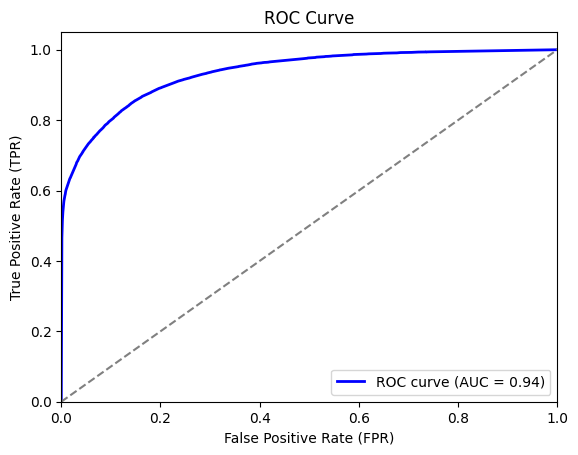


SVM Evaluation:
Accuracy: 0.7202
Precision: 0.7328
Recall: 0.7202
F1-score: 0.7246


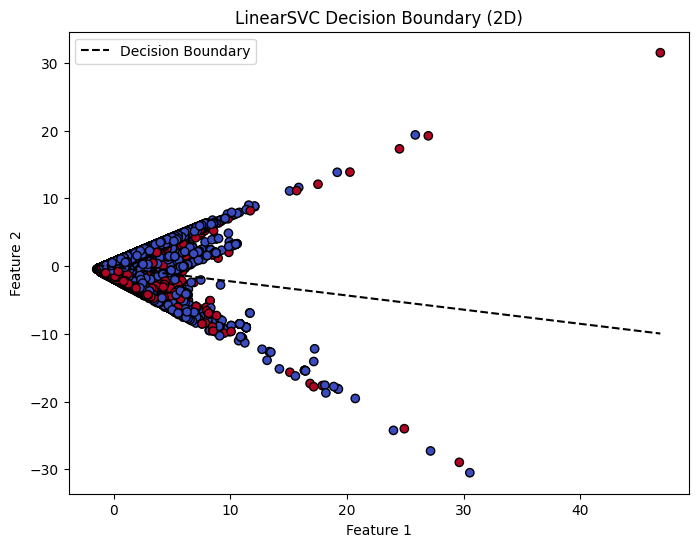

In [19]:
#Đánh giá hiệu suất mô hình
def evaluate_model_rf(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_probs = model.predict_proba(X_test)[:, 1] #lấy xác suất các mẫu có lỗ hổng
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred, average='weighted'):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred, average='weighted'):.4f}")
    print(f"F1-score: {f1_score(y_test, y_pred, average='weighted'):.4f}")
    print(f"roc_auc: {roc_auc_score(y_test, y_probs)}")
    # Vẽ ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (AUC = {roc_auc_score(y_test, y_probs):.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Đường phân loại ngẫu nhiên
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

def evaluate_model_svm(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred, average='weighted'):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred, average='weighted'):.4f}")
    print(f"F1-score: {f1_score(y_test, y_pred, average='weighted'):.4f}")
    
    # Vẽ đồ thị
    plt.figure(figsize=(8, 6))
    plt.scatter(X_train_scaled[:, 0], X_train_scaled[:, 1], c=y_train, cmap='coolwarm', edgecolors='k')

    # Tính đường quyết định (decision boundary)
    w = svm_model.coef_[0]
    b = svm_model.intercept_[0]
    x_vals = np.linspace(X_train_scaled[:, 0].min(), X_train_scaled[:, 0].max(), 100)
    y_vals = -(w[0] * x_vals + b) / w[1]

    plt.plot(x_vals, y_vals, 'k--', label='Decision Boundary')
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("LinearSVC Decision Boundary (2D)")
    plt.legend()
    plt.show()
    
    
print("Random Forest Evaluation:")
evaluate_model_rf(rf_model, X_test, y_test)

print("\nSVM Evaluation:")
evaluate_model_svm(svm_model, X_test_scaled, y_test)

